In [10]:
import pandas as pd
import networkx as nx
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

# 1/
df = pd.read_csv('hero-network.csv')  

G = nx.from_pandas_edgelist(df, 'hero1', 'hero2')

G = nx.Graph(G)

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
degree_sequence = [d for _, d in G.degree()]
avg_degree = sum(degree_sequence) / num_nodes
std_degree = pd.Series(degree_sequence).std()
min_degree = min(degree_sequence)
max_degree = max(degree_sequence)

# Create a DataFrame with degrees
degree_df = pd.DataFrame(G.degree(), columns=['character', 'degree'])

# Sort by degree in ascending order
degree_df_sorted = degree_df.sort_values(by='degree', ascending=True)

# Save to CSV
degree_df_sorted.to_csv('hero_degrees_sorted.csv', index=False)

degree_centrality = nx.degree_centrality(G)
dc_series = pd.Series(degree_centrality)

max_dc = dc_series.idxmax(), dc_series.max()
min_dc = dc_series.idxmin(), dc_series.min()
avg_diff = (dc_series - dc_series.mean()).abs()
close_to_avg = dc_series[avg_diff.nsmallest(3).index].items()

print(f"Network Statistics:")
print(f"Total Nodes: {num_nodes}")
print(f"Total Edges: {num_edges}")
print(f"Average Degree: {avg_degree:.3f}")
print(f"Standard Deviation: {std_degree:.3f}")
print(f"Minimum Degree: {min_degree}")
print(f"Maximum Degree: {max_degree}\n")

print(f"Most Connected: {max_dc[0]} ({max_dc[1]:.5f})")
print(f"Least Connected: {min_dc[0]} ({min_dc[1]:.5f})")
print("\nClose to Average Centrality:")
for char, score in close_to_avg:
    print(f"{char}: {score:.5f}")

Network Statistics:
Total Nodes: 6426
Total Edges: 167219
Average Degree: 52.045
Standard Deviation: 113.658
Minimum Degree: 1
Maximum Degree: 1908

Most Connected: CAPTAIN AMERICA (0.29696)
Least Connected: AZRAEL (0.00016)

Close to Average Centrality:
JONES, TAMMY ANNE: 0.00809
JONES, LORRAINE LORR: 0.00809
JONES, DANIEL DANNY: 0.00809


In [9]:
# 2/
deg_dict = dict(G.degree())

degree_to_nodes = {}
for node, deg in deg_dict.items():
    degree_to_nodes.setdefault(deg, []).append(node)

results = []
for k, nodes in sorted(degree_to_nodes.items()):
    if len(nodes) < 2:
        continue

    dists = []
    for u, v in combinations(nodes, 2):
        try:
            d = nx.shortest_path_length(G, source=u, target=v)
            dists.append(d)
        except nx.NetworkXNoPath:
            pass

    if len(dists) > 0:
        avg_dist = np.mean(dists)
        var_dist = np.var(dists, ddof=0)
    else:
        avg_dist = np.nan
        var_dist = np.nan

    results.append({
        'degree': k,
        'n_nodes': len(nodes),
        'avg_distance': avg_dist,
        'var_distance': var_dist
    })

df_summary = pd.DataFrame(results).set_index('degree')
print(df_summary)

#Save the summary to a CSV file
df_summary.to_csv('degree_summary.csv')

        n_nodes  avg_distance  var_distance
degree                                     
1            53      3.270376      0.264671
2            86      3.260739      0.260606
3           104      3.226475      0.264056
4           150      3.104609      0.222704
5           182      3.139336      0.249968
...         ...           ...           ...
497           2      1.000000      0.000000
526           2      1.000000      0.000000
539           2      1.000000      0.000000
585           2      1.000000      0.000000
922           2      1.000000      0.000000

[242 rows x 3 columns]


In [4]:
# 3/
results = []
for k, nodes in sorted(degree_to_nodes.items()):
    if len(nodes) < 2:
        continue

    sims = []
    for u, v in combinations(nodes, 2):
        nbrs_u = set(G.neighbors(u))
        nbrs_v = set(G.neighbors(v))
        if k > 0:
            sim = len(nbrs_u & nbrs_v) / np.sqrt(k * k)
            sims.append(sim)

    if sims:
        avg_sim  = np.mean(sims)
        std_sim  = np.std(sims, ddof=0)
    else:
        avg_sim, std_sim = np.nan, np.nan

    results.append({
        'degree':    k,
        'n_nodes':   len(nodes),
        'avg_sim':   avg_sim,
        'std_sim':   std_sim
    })

df_struct_eq = pd.DataFrame(results).set_index('degree')
print(df_struct_eq)

        n_nodes   avg_sim   std_sim
degree                             
1            53  0.023948  0.152886
2            86  0.014227  0.087931
3           104  0.011265  0.073284
4           150  0.017651  0.085114
5           182  0.016356  0.087057
...         ...       ...       ...
497           2  0.382294  0.000000
526           2  0.359316  0.000000
539           2  0.278293  0.000000
585           2  0.213675  0.000000
922           2  0.427332  0.000000

[242 rows x 3 columns]


In [5]:
# 4.1/
closeness_centrality = nx.closeness_centrality(G)
cc_series = pd.Series(closeness_centrality)

# Task 4.1: Global
cmean = cc_series.mean()
max_cc = (cc_series.idxmax(), cc_series.max())
min_cc = (cc_series.idxmin(), cc_series.min())
avg_diff_cc = (cc_series - cmean).abs()
close_to_avg_cc = cc_series[avg_diff_cc.nsmallest(3).index]

print("\nNetwork Statistics (Closeness Centrality):")
print(f"Most Central (Closeness): {max_cc[0]} ({max_cc[1]:.3f})")
print(f"Least Central (Closeness): {min_cc[0]} ({min_cc[1]:.3f})")
print("Close to Average Closeness Centrality:")
for char, score in close_to_avg_cc.items():
    print(f"- {char}: {score:.3f}")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Hieu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Hieu\AppData\Local\Temp\ipykernel_7976\2394955199.py", line 2, in <module>
    closeness_centrality = nx.closeness_centrality(G)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Hieu\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\utils\decorators.py", line 788, in func
    return argmap._lazy_compile(__wrapper)(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<class 'networkx.utils.decorators.argmap'> compilation 32", line 3, in argmap_closeness_centrality_29
    import gzip
            ^^^
  File "c:\Users\Hieu\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\utils\backends.py", line 967, in __call__
    return self.orig_func(*args, **kwargs)
        

In [ ]:
# 4.2/
results_cc_dist = []
for val in sorted(set(cc_series.values)):
    group = [n for n, c in closeness_centrality.items() if c == val]
    if len(group) < 2:
        results_cc_dist.append({'centrality_value': val, 'avg_distance': np.nan, 'variance': np.nan})
    else:
        dists = []
        for u, v in combinations(group, 2):
            try:
                d = nx.shortest_path_length(G, source=u, target=v)
                dists.append(d)
            except nx.NetworkXNoPath:
                continue
        dists = np.array(dists)
        results_cc_dist.append({
            'centrality_value': val,
            'avg_distance': dists.mean() if dists.size else np.nan,
            'variance': dists.var(ddof=0) if dists.size else np.nan
        })
cc_dist_df = pd.DataFrame(results_cc_dist)
print("\nAverage Distance by Closeness Centrality:")
print(cc_dist_df.to_string(index=False))


Average Distance by Closeness Centrality:
 centrality_value  avg_distance  variance
         0.000156      1.000000  0.000000
         0.000934      1.000000  0.000000
         0.000996           NaN       NaN
         0.001107      1.000000  0.000000
         0.001245      1.000000  0.000000
         0.259675      1.000000  0.000000
         0.260501           NaN       NaN
         0.262309      2.000000  0.000000
         0.262319      1.666667  0.222222
         0.262330           NaN       NaN
         0.263901      1.000000  0.000000
         0.264262           NaN       NaN
         0.264272      1.000000  0.000000
         0.264283      1.000000  0.000000
         0.264404           NaN       NaN
         0.267615           NaN       NaN
         0.268143           NaN       NaN
         0.272652           NaN       NaN
         0.276247      1.000000  0.000000
         0.285953      1.000000  0.000000
         0.288575           NaN       NaN
         0.288588      1.000000  

In [ ]:
# 4.3/
nodes = list(G.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}
A = nx.to_numpy_array(G, nodelist=nodes)

# 4.3/
results_cc_struct = []
for val in sorted(set(closeness_centrality.values())):
    group = [n for n, c in closeness_centrality.items() if c == val]
    idxs = [node_to_idx[n] for n in group if n in node_to_idx]
    sims = []
    for i, j in combinations(idxs, 2):
        u = A[i]
        v = A[j]
        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)
        sim = np.dot(u, v) / (norm_u * norm_v) if norm_u and norm_v else 0.0
        sims.append(sim)
    sims = np.array(sims)
    results_cc_struct.append({
        'centrality_value': val,
        'avg_similarity': sims.mean() if sims.size > 0 else np.nan,
        'std_similarity': sims.std(ddof=0) if sims.size > 0 else np.nan
    })
cc_struct_df = pd.DataFrame(results_cc_struct)
print("\nStructural Equivalence by Closeness Centrality:")
print(cc_struct_df.to_string(index=False))



Structural Equivalence by Closeness Centrality:
 centrality_value  avg_similarity  std_similarity
         0.000156        0.000000    0.000000e+00
         0.000934        0.833333    0.000000e+00
         0.000996             NaN             NaN
         0.001107        0.857143    0.000000e+00
         0.001245        0.875000    1.110223e-16
         0.259675        0.666667    1.110223e-16
         0.260501             NaN             NaN
         0.262309        0.750000    0.000000e+00
         0.262319        0.800000    0.000000e+00
         0.262330             NaN             NaN
         0.263901        0.750000    0.000000e+00
         0.264262             NaN             NaN
         0.264272        0.750000    0.000000e+00
         0.264283        0.800000    0.000000e+00
         0.264404             NaN             NaN
         0.267615             NaN             NaN
         0.268143             NaN             NaN
         0.272652             NaN             NaN
 

In [ ]:
# 5/
components = list(nx.connected_components(G))
components_sorted = sorted(components, key=len, reverse=True)
largest_comp_nodes = components_sorted[0]
G_largest = G.subgraph(largest_comp_nodes)
diameter_largest = nx.diameter(G_largest)

print(f"Total number of connected components: {len(components)}")
print("Sizes of the 3 largest components:", [len(c) for c in components_sorted[:3]])
print(f"Diameter of the largest component: {diameter_largest}")

Total number of connected components: 4
Sizes of the 3 largest components: [6408, 9, 7]
Diameter of the largest component: 5


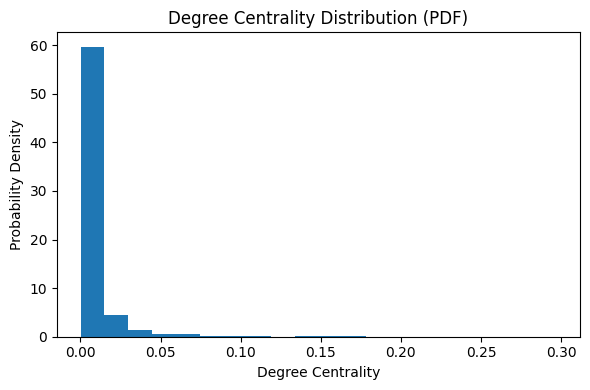

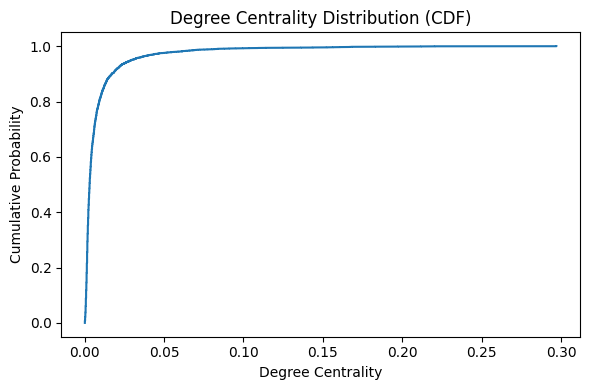

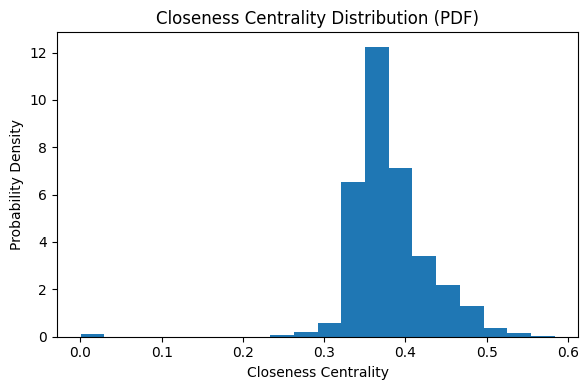

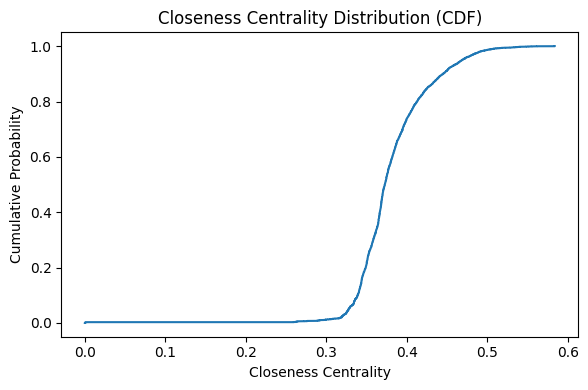

In [ ]:
# 6/
deg_cent = nx.degree_centrality(G)
clo_cent = nx.closeness_centrality(G)

deg_vals = np.array(list(deg_cent.values()))
clo_vals = np.array(list(clo_cent.values()))

# --- Degree Centrality PDF ---
plt.figure(figsize=(6,4))
plt.hist(deg_vals, bins=20, density=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Probability Density')
plt.title('Degree Centrality Distribution (PDF)')
plt.tight_layout()
plt.show()

# --- Degree Centrality CDF ---
sorted_deg = np.sort(deg_vals)
cdf_deg = np.arange(1, len(sorted_deg)+1) / len(sorted_deg)
plt.figure(figsize=(6,4))
plt.step(sorted_deg, cdf_deg, where='post')
plt.xlabel('Degree Centrality')
plt.ylabel('Cumulative Probability')
plt.title('Degree Centrality Distribution (CDF)')
plt.tight_layout()
plt.show()

# --- Closeness Centrality PDF ---
plt.figure(figsize=(6,4))
plt.hist(clo_vals, bins=20, density=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Probability Density')
plt.title('Closeness Centrality Distribution (PDF)')
plt.tight_layout()
plt.show()

# --- Closeness Centrality CDF ---
sorted_clo = np.sort(clo_vals)
cdf_clo = np.arange(1, len(sorted_clo)+1) / len(sorted_clo)
plt.figure(figsize=(6,4))
plt.step(sorted_clo, cdf_clo, where='post')
plt.xlabel('Closeness Centrality')
plt.ylabel('Cumulative Probability')
plt.title('Closeness Centrality Distribution (CDF)')
plt.tight_layout()
plt.show()

In [ ]:
# 7/
import sqlite3

clust_dict = nx.clustering(G) 

db_path = 'clustering_alt.db'
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('''
    CREATE TABLE IF NOT EXISTS node_clustering (
        node TEXT PRIMARY KEY,
        clustering_coeff REAL
    )
''')

rows = [(str(node), float(coeff)) for node, coeff in clust_dict.items()]
c.executemany('''
    INSERT OR REPLACE INTO node_clustering (node, clustering_coeff)
    VALUES (?, ?)
''', rows)

conn.commit()
conn.close()

print(f"Saved clustering coefficients for {len(rows)} nodes to '{db_path}'.")

Saved clustering coefficients for 6426 nodes to 'clustering_alt.db'.


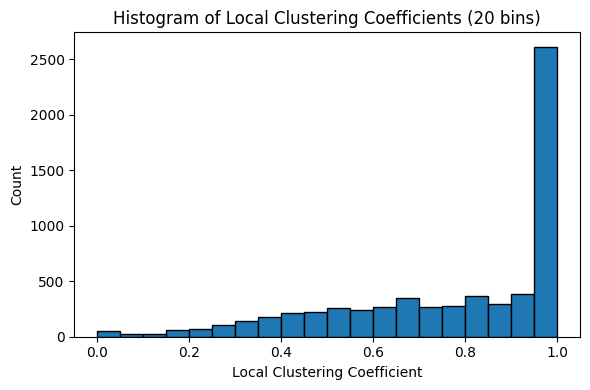

Fitted power‑law:  p(x) ∝ x^(-1.370),  xmin=0.049
Empirical R² of the power‑law fit: -0.6664


In [ ]:
# 8/
import powerlaw
values = np.array(list(clust_dict.values()))

bins = np.linspace(0, 1, 21)
plt.figure(figsize=(6,4))
plt.hist(values, bins=bins, edgecolor='black')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Count')
plt.title('Histogram of Local Clustering Coefficients (20 bins)')
plt.tight_layout()
plt.show()

data = values[values > 0]
fit = powerlaw.Fit(data, xmin=data.min())  
alpha = fit.power_law.alpha
xmin  = fit.power_law.xmin
print(f"Fitted power‑law:  p(x) ∝ x^(-{alpha:.3f}),  xmin={xmin:.3f}")

hist, bin_edges = np.histogram(data, bins=20, range=(xmin, data.max()), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

C = (alpha - 1) * xmin**(alpha - 1)
pdf_theo = C * bin_centers**(-alpha)

y_obs = hist
y_pred = pdf_theo
ss_res = np.sum((y_obs - y_pred)**2)
ss_tot = np.sum((y_obs - y_obs.mean())**2)
r_squared = 1 - ss_res / ss_tot
print(f"Empirical R² of the power‑law fit: {r_squared:.4f}")